In [149]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf # linear modeling
import xgboost as xgb
import statsmodels.formula.api as smf # linear modeling
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn import preprocessing

## Preparing the Data

### Checking for Missing Values

In [150]:
math_class = pd.read_csv('./data/student-mat.csv')
portuguese_class = pd.read_csv('./data/student-por.csv')

In [151]:
pd.isnull(portuguese_class).any()

school        False
sex           False
age           False
address       False
famsize       False
Pstatus       False
Medu          False
Fedu          False
Mjob          False
Fjob          False
reason        False
guardian      False
traveltime    False
studytime     False
failures      False
schoolsup     False
famsup        False
paid          False
activities    False
nursery       False
higher        False
internet      False
romantic      False
famrel        False
freetime      False
goout         False
Dalc          False
Walc          False
health        False
absences      False
G1            False
G2            False
G3            False
dtype: bool

At the moment, it does not look like we have any values in the data that are null/missing. This makes us think that the data set has another way of representing that data that is missing (than leaving it blank), which will be investigated further in exploratory data analysis.

### Combining the Data Sets
Since both data sets include data from students in both schools and both schools are in Portugal, we believe it is appropriate to combine the two data sets.

In [152]:
math_class['class'] = 'math'
portuguese_class['class'] = 'portuguese'

combined_data = pd.concat([math_class, portuguese_class])

# Changing categorical variables from string to categorical
combined_data.loc[:, combined_data.dtypes == object] = combined_data.loc[:, combined_data.dtypes == object].astype('category')

### Adding New Variables

Having drinking split up into workday and weekend drinking does not make much sense since we are trying to predict drinking level overall. As such, we will average these two columns into an overall_drinking feature. Furthermore, it has been proven that [poorer people are more negatively affected by alcohol](https://www.thelancet.com/journals/lanpub/article/PIIS2468-2667(17)30078-6/fulltext?elsca1=tlxpr), meaning that they are at higher risk for dangerous drinking behaviors and at higher risk for noticeable effects of excessive drinking. While not a perfect measure, [poverty is strongly correlated with low education level](https://poverty.ucdavis.edu/faq/how-does-level-education-relate-poverty), so we will define our new feature, 'low_income', as 1 when both parents have an education level of <= 2 (9th grade or less) and 0 otherwise.

In [153]:
# Averaging workday and weekend drinking

# We want to make this variable really varied so it doesn't get lost in one through 5
combined_data['overall_drinking'] = (combined_data['Walc'] + combined_data['Dalc'])
combined_data.overall_drinking = combined_data.overall_drinking.round()

# Adding our new feature
combined_data['low_income'] = np.where((combined_data['Fedu'] <= 2) & (combined_data['Medu'] <= 2), 1, 0)

In [154]:
combined_data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,overall_drinking,low_income
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,1.494253,2.284483,3.543103,4.434866,11.213602,11.246169,11.341954,3.778736,0.409004
std,1.239975,1.124907,1.099938,0.731727,0.834353,0.656142,0.933401,1.031507,1.152575,0.911714,1.285105,1.424703,6.210017,2.983394,3.285071,3.864796,1.988434,0.491886
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000,2.000000,0.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000,3.000000,0.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000,5.000000,1.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000,10.000000,1.000000


## Exploratory Data Analysis

### Correlations
As a first look, we decided to look at correlations between the various features in the data set. 

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 18 Text xticklabel objects>)

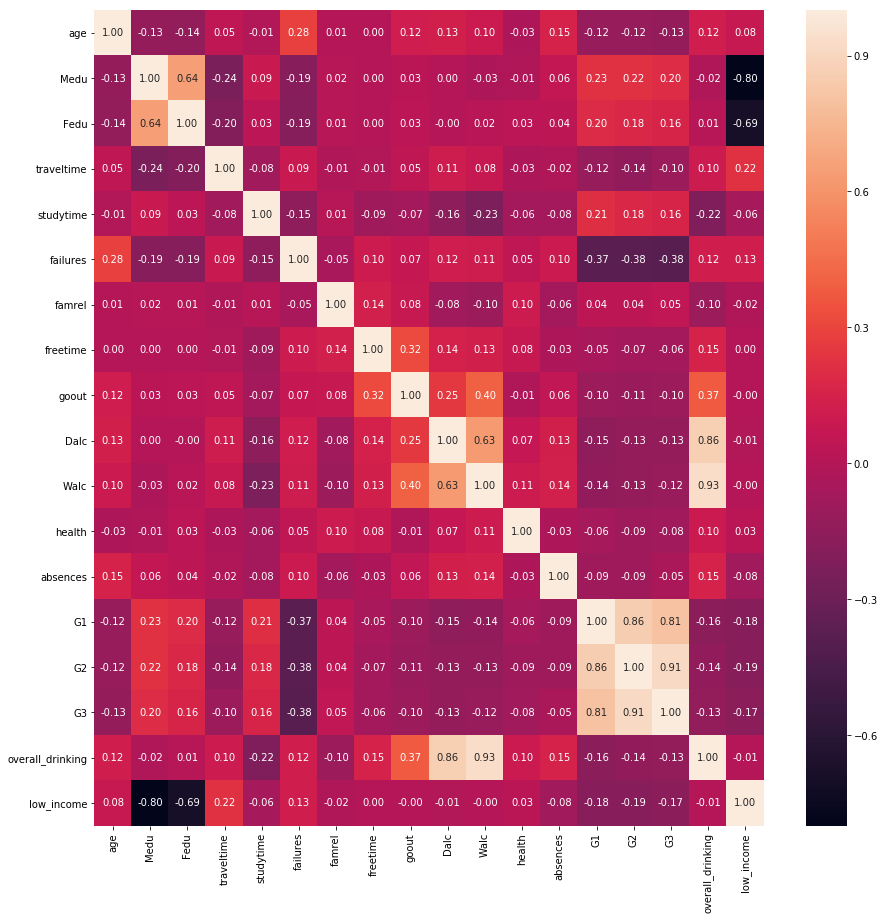

In [155]:
plt.figure(figsize=(15,15))
sns.heatmap(combined_data.corr(),annot = True,fmt = ".2f")
plt.xticks(rotation=90)

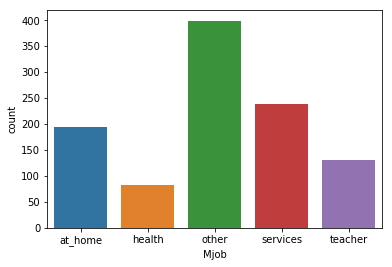

In [156]:
sns.countplot(x="Mjob", data=combined_data)

### Feature Selection

First we are going to convert the features that are not represented as integers into integers, and then we will be able to use sklearn to perform machine learning on our data. 

In [189]:
# Renaming to data to save time
data = combined_data

As we are trying to predict overall drinking for the students, we need to take out daily alcohol and weekly alcohol consumption from our train/test split as well as from feature selection and model training. This is because these values represent what we are trying to predict, so leaving them in the dataset will result in inaccurate predictions. 

In [190]:
# Rename class column to reduce errors that occur
# Drop our big predictors Dalc, Walc, and goout because they are all indicators of drinking

data['cls'] = data['class']
data = data.drop(['class'], axis=1)
data = data.drop(['Dalc'], axis=1)
data = data.drop(['Walc'], axis=1)
data = data.drop(['goout'], axis=1)

In [191]:
data.dtypes

school              category
sex                 category
age                    int64
address             category
famsize             category
Pstatus             category
Medu                   int64
Fedu                   int64
Mjob                category
Fjob                category
reason              category
guardian            category
traveltime             int64
studytime              int64
failures               int64
schoolsup           category
famsup              category
paid                category
activities          category
nursery             category
higher              category
internet            category
romantic            category
famrel                 int64
freetime               int64
health                 int64
absences               int64
G1                     int64
G2                     int64
G3                     int64
overall_drinking       int64
low_income             int64
cls                 category
dtype: object

We encode all of our categorical data into integers so that we can look at the correlation it has with overall drinking.

In [192]:
# Use sklearn's LabelEncoder to transform these categorical data
school = preprocessing.LabelEncoder()
sex = preprocessing.LabelEncoder()
address = preprocessing.LabelEncoder()
famsize = preprocessing.LabelEncoder()
Pstatus = preprocessing.LabelEncoder()
Mjob = preprocessing.LabelEncoder()
Fjob = preprocessing.LabelEncoder()
reason = preprocessing.LabelEncoder()
guardian = preprocessing.LabelEncoder()
schoolsup = preprocessing.LabelEncoder()
famsup = preprocessing.LabelEncoder()
paid = preprocessing.LabelEncoder()
activities = preprocessing.LabelEncoder()
nursery = preprocessing.LabelEncoder()
higher = preprocessing.LabelEncoder()
internet = preprocessing.LabelEncoder()
romantic = preprocessing.LabelEncoder()
class_encoder = preprocessing.LabelEncoder()
drinking = preprocessing.LabelEncoder()

# Establish the relationship between categorical labels and integers
school.fit(data.school)
sex.fit(data.sex)
address.fit(data.address)
famsize.fit(data.famsize)
Pstatus.fit(data.Pstatus)
Mjob.fit(data.Mjob)
Fjob.fit(data.Fjob)
reason.fit(data.reason)
guardian.fit(data.guardian)
schoolsup.fit(data.schoolsup)
famsup.fit(data.famsup)
paid.fit(data.paid)
activities.fit(data.activities)
nursery.fit(data.nursery)
higher.fit(data.higher)
internet.fit(data.internet)
romantic.fit(data.romantic)
class_encoder.fit(data.cls)
drinking.fit(data.overall_drinking)

# Create your integer outcome by transforming the categorical column
data['school'] = school.transform(data.school)
data['sex'] = sex.transform(data.sex)
data['address'] = address.transform(data.address)
data['famsize'] = famsize.transform(data.famsize)
data['Pstatus'] = Pstatus.transform(data.Pstatus)
data['Mjob'] = Mjob.transform(data.Mjob)
data['Fjob'] = Fjob.transform(data.Fjob)
data['reason'] = reason.transform(data.reason)
data['guardian'] = guardian.transform(data.guardian)
data['schoolsup'] = schoolsup.transform(data.schoolsup)
data['famsup'] = famsup.transform(data.famsup)
data['paid'] = paid.transform(data.paid)
data['activities'] = activities.transform(data.activities)
data['nursery'] = nursery.transform(data.nursery)
data['higher'] = higher.transform(data.higher)
data['internet'] = internet.transform(data.internet)
data['romantic'] = romantic.transform(data.romantic)
data['cls'] = class_encoder.transform(data.cls)
data['overall_drinking'] = drinking.transform(data.overall_drinking)

In [193]:
data.dtypes
data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'health',
       'absences', 'G1', 'G2', 'G3', 'overall_drinking', 'low_income', 'cls'],
      dtype='object')

In [194]:
train_features, test_features, train_outcome, test_outcome = train_test_split(
    data,
    data.overall_drinking,
    test_size=0.30
)

In [195]:
# An algorithmic approach to feature selection
# Source : https://planspace.org/20150423-forward_selection_with_statsmodels/
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [196]:
# We are using our training data here as well to reduce the bias of our model and features
model = forward_selected(train_features, 'overall_drinking')

In [197]:
print (model.model.formula)
print (model.rsquared_adj)

overall_drinking ~ sex + studytime + age + absences + traveltime + paid + G2 + famsize + freetime + famrel + cls + Pstatus + activities + health + Fjob + Fedu + nursery + 1
0.21583356567714884


### Features We Chose

### From the forward selection process we have chosen the following variables to use in our analysis: 

1) sex
2) age
3) studytime
4) G1
5) famrel
6) freetime
7) absences
8) cls
9) paid
10) health
11) guardian
12) famsize
13) nursery
14) traveltime
15) internet
16) Fjob
17) school
18) Pstatus


In [198]:
# Copy features from above into features we will use array and use this for a pipeline model
features_we_will_use = ['sex', 'age', 'studytime', 'G1', 'famrel', 'freetime', 'absences', 'cls', 'paid', 'health', 'guardian', 'famsize', 'nursery', 'traveltime', 'internet', 'Fjob', 'school', 'Pstatus']
#small_data = data[features_we_will_use]

train_features = train_features[features_we_will_use]
test_features = test_features[features_we_will_use]

### Pipeline Modeling - KNN Classifier

In [199]:
# Created a pipeline (source code from lecture)
pipe = make_pipeline(Imputer(), MinMaxScaler(), KNeighborsClassifier())

# Define a grid to search through
param_grid = {'kneighborsclassifier__n_neighbors':range(1, 20)}

# Define a grid to search through (including the degree of polynomial)
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error") # you may want to specify more parameters!

In [200]:
grid.fit(train_features, train_outcome)
grid.score(test_features, test_outcome)

-1.6815286624203822

In [201]:
grid.cv_results_['params'][grid.best_index_]

{'kneighborsclassifier__n_neighbors': 8}

In [203]:
knn_test_predict = grid.predict(test_features)

In [204]:
accuracy_score(knn_test_predict, test_outcome, normalize=True)

0.3471337579617834

With an accuracy score on average between 0.3-0.5. This model is rather predictive of final scores.

### Pipeline Modeling - XGB Classifier

In [205]:
pipe2 = make_pipeline(Imputer(), MinMaxScaler(), XGBClassifier())

In [206]:
param_grid2 = {}
grid2 = GridSearchCV(pipe2, param_grid2, scoring="neg_mean_absolute_error") 


In [207]:
grid2.fit(train_features, train_outcome)
grid2.score(test_features, test_outcome)
xgb_test_predict = grid2.predict(test_features)

/Users/emilytao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/emilytao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/emilytao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/emilytao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

In [208]:
accuracy_score(xgb_test_predict, test_outcome, normalize=True)

0.4012738853503185

The XGBClassifier is reporting a score of around 0.4-0.5 on average. This score is normalized to 1.


### Graph of Differences between KNN and XGB Predictions

In [224]:
#xgb_list = xgb_test_predict.tolist()
#knn_list = knn_test_predict.tolist()
# map against test outcome

In [238]:
test_features['xgb_predict'] = xgb_test_predict
test_features['knn_predict'] = knn_test_predict
test_features['real_outcome'] = test_outcome

In [241]:
test_features.head()

,sex,age,studytime,G1,famrel,freetime,absences,cls,paid,health,...,famsize,nursery,traveltime,internet,Fjob,school,Pstatus,xgb_predict,knn_predict,real_outcome
209,0,17,2,14,4,3,8,1,0,5,...,1,1,1,1,3,0,1,2,0,0
351,1,17,2,13,4,5,2,0,1,3,...,0,1,2,1,2,1,1,2,0,3
273,1,17,2,15,3,5,2,0,1,1,...,0,0,1,0,0,0,1,0,0,2
276,1,16,1,15,4,3,7,1,0,4,...,0,1,3,1,2,0,1,1,3,0
629,0,17,1,7,3,5,4,1,0,1,...,0,1,1,1,2,1,1,0,0,2


In [246]:
#index_test_features = test_features.index.values
test_features.describe()

,sex,age,studytime,G1,famrel,freetime,absences,cls,paid,health,...,famsize,nursery,traveltime,internet,Fjob,school,Pstatus,xgb_predict,knn_predict,real_outcome
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,...,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,0.433121,16.770701,1.968153,11.458599,3.914013,3.159236,4.248408,0.617834,0.226115,3.535032,...,0.273885,0.799363,1.522293,0.805732,2.299363,0.273885,0.898089,0.796178,0.742038,1.831210
std,0.496298,1.216881,0.826250,3.027015,0.929939,1.026857,6.241832,0.486692,0.418982,1.412082,...,0.446663,0.401116,0.702219,0.396267,0.845699,0.446663,0.303014,1.387939,1.432290,2.033312
min,0.000000,15.000000,1.000000,5.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.000000,1.000000,9.000000,4.000000,3.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,17.000000,2.000000,11.000000,4.000000,3.000000,2.000000,1.000000,0.000000,4.000000,...,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,18.000000,2.000000,14.000000,5.000000,4.000000,6.000000,1.000000,0.000000,5.000000,...,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,3.000000
max,1.000000,21.000000,4.000000,19.000000,5.000000,5.000000,56.000000,1.000000,1.000000,5.000000,...,1.000000,1.000000,4.000000,1.000000,4.000000,1.000000,1.000000,8.000000,8.000000,8.000000


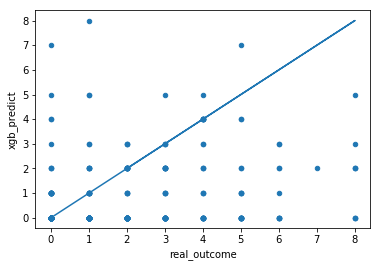

In [249]:
test_features.plot('real_outcome', 'xgb_predict', kind='scatter')
plt.plot(test_features.real_outcome, test_features.real_outcome)
plt.show()

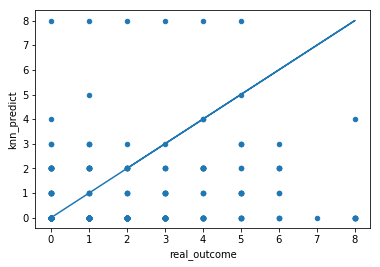

In [250]:
test_features.plot('real_outcome', 'knn_predict', kind='scatter')
plt.plot(test_features.real_outcome, test_features.real_outcome)
plt.show()